In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\astal\AppData\Local\Temp\ipykernel_11612\819026651.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ipykernel_11612\819026651.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ipykernel_11612\819026651.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ipykernel_11612\819026651.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ip

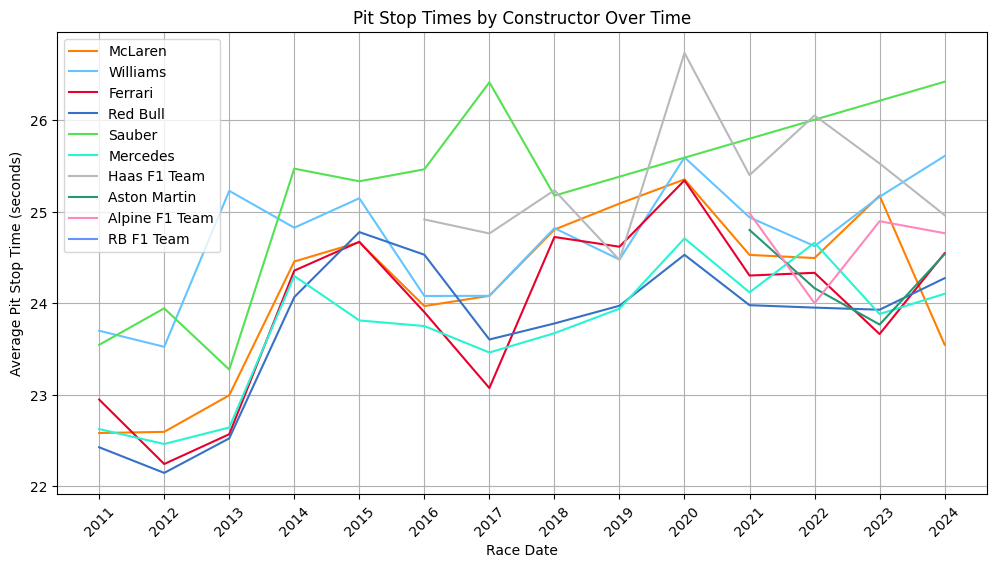

In [68]:
# Pit Stops df only contains data from the 2011 season
pit_stops_df = pd.read_csv('datasets/pit_stops.csv') # pit stop dataset
pit_stops_df['milliseconds'] = pit_stops_df['milliseconds'] / 1000 # convert to seconds
pit_stops_df = pit_stops_df[pit_stops_df['milliseconds'] < 50]
unique_race_ids = pit_stops_df['raceId'].unique() # unique race IDs

results_df = pd.read_csv('datasets/results.csv') # race results dataset
results_df = results_df[results_df['raceId'].isin(unique_race_ids)]
results_df.drop(columns=['resultId', 'number', 'positionText', 'position', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId'], inplace=True)

constructors_df = pd.read_csv('datasets/constructors.csv') # constructors dataset
constructors_df.drop(columns=['nationality', 'constructorRef', 'url'], inplace=True)

races_df = pd.read_csv('datasets/races.csv') # races dataset
# needed to extract the race date for the time series
races_df = races_df[races_df['raceId'].isin(unique_race_ids)]
races_df = races_df[['raceId', 'year']]

team_colors = {
    'McLaren': '#FF8000',
    'Mercedes': '#27F4D2',
    'Red Bull': '#3671C6',
    'Ferrari': '#E8002D',
    'Alpine F1 Team': '#FF87BC',
    'RB F1 Team': '#6692FF',
    'Aston Martin': '#229971',
    'Williams': '#64C4FF',
    'Sauber': '#52E252',
    'Haas F1 Team': '#B6BABD'
}


merged_df = pd.merge(pit_stops_df, results_df, on=['raceId', 'driverId'], how='left')
merged_df = pd.merge(merged_df, races_df, on='raceId')

grouped_df = merged_df.groupby(['year', 'constructorId'])[['milliseconds']].mean().reset_index()
grouped_df = pd.merge(grouped_df, constructors_df, on='constructorId')



current_constructors = grouped_df[grouped_df['year'] == 2024]['constructorId']
current_constructors_pit_data_df = grouped_df[grouped_df['constructorId'].isin(current_constructors)]

plt.figure(figsize=(12, 6))

# Loop through each constructor and plot its pit stop times over races
for constructor in current_constructors_pit_data_df['constructorId'].unique():
    constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
    constructor_name = constructor_data['name'].iloc[0]
    color = team_colors.get(constructor_name, '#000000')
    plt.plot(
        constructor_data['year'], 
        constructor_data['milliseconds'], 
        label=constructor_name,
        color=color)

plt.xlabel('Race Date')
plt.ylabel('Average Pit Stop Time (seconds)')
plt.title('Pit Stop Times by Constructor Over Time')
plt.legend()
xticks_years = sorted(current_constructors_pit_data_df['year'].unique()) 
plt.xticks(xticks_years)
plt.xticks(rotation=45)
plt.grid()
plt.show()

c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib

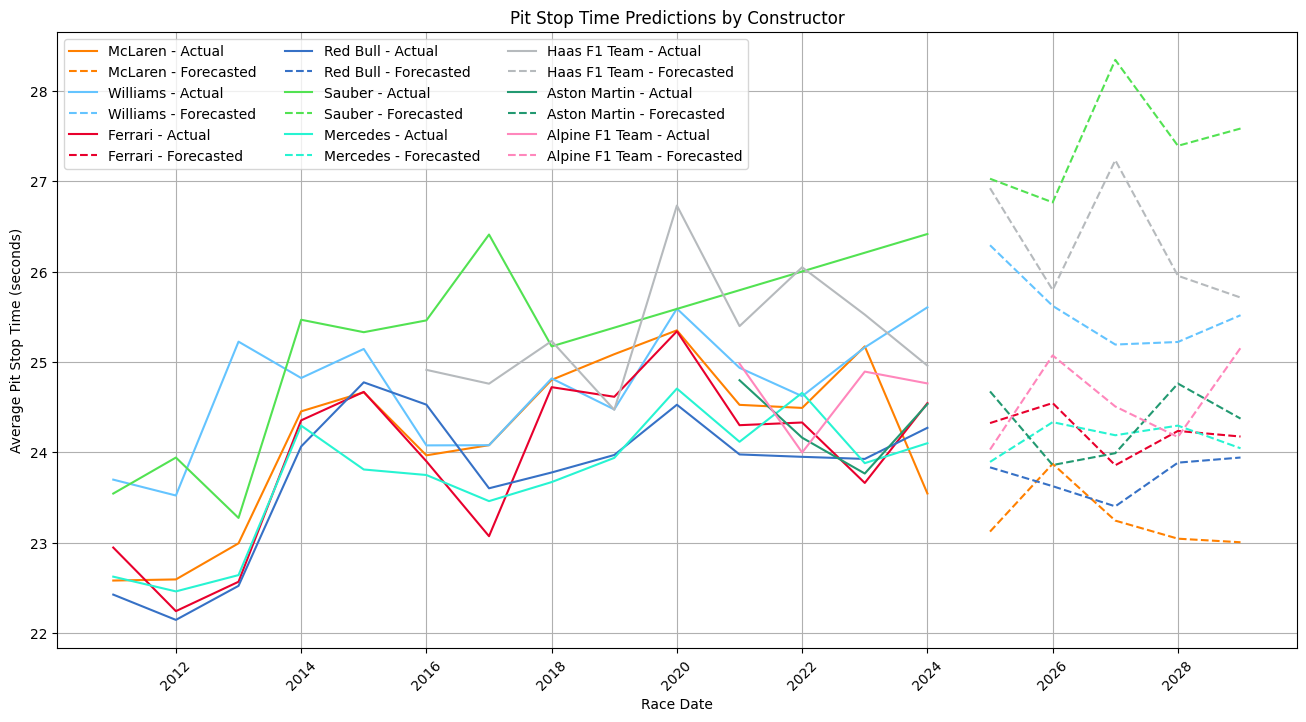

In [115]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from matplotlib.ticker import MaxNLocator


teams = ['McLaren', 'Williams', 'Ferrari', 'Red Bull', 'Mercedes', 'Aston Martin', 'Sauber', 'Haas F1 Team', 'Alpine F1 Team']

forecasting_df = current_constructors_pit_data_df[current_constructors_pit_data_df['name'].isin(teams)]
forecasting_df['name'].unique()

# Fit ARIMA model for each constructor
constructor_predictions = {}

for constructor in forecasting_df['constructorId'].unique():
    constructor_data = forecasting_df[forecasting_df['constructorId'] == constructor]
    
    # Fit ARIMA model (you can fine-tune the parameters based on your data)
    model = ARIMA(constructor_data['milliseconds'], order=(5,1,0))  # (p, d, q) parameters may need optimization
    model_fit = model.fit()

    # Forecast the next N races (e.g., 5 races)
    forecast = model_fit.forecast(steps=5)
    
    # Store the forecast for this constructor
    constructor_predictions[constructor] = forecast

# Visualize forecasts for each constructor
plt.figure(figsize=(16, 8))

for constructor, forecast in constructor_predictions.items():
    constructor_data = forecasting_df[forecasting_df['constructorId'] == constructor]
    constructor_name = constructor_data['name'].iloc[0]
    color = team_colors.get(constructor_name, '#000000')
    
    plt.plot(constructor_data['year'], constructor_data['milliseconds'], label=f'{constructor_name} - Actual', color=color)
    
    # Add forecasted pit stop times
    future_dates = [2025, 2026, 2027, 2028, 2029]
    plt.plot(future_dates, forecast, label=f'{constructor_name} - Forecasted', linestyle='dashed', color=color)

plt.xticks(rotation=45)
plt.xlabel('Race Date')
plt.ylabel('Average Pit Stop Time (seconds)')
plt.title('Pit Stop Time Predictions by Constructor')
plt.legend(loc='upper left', ncols=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()


